In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import signal
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
import optuna
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.animation as animation
import os
from torchvision.io import read_image
from torchvision.transforms import v2
import torchvision
from torchvision.io import read_image, ImageReadMode

Напишем функцию read_data, который будет приводить dataframe к удобному виду.

In [2]:
def read_data(path_to_file: str) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    data = data[['time', 'displacements_x', 'displacements_y', 'angular_velocity', 'load_value', 'gear_fault_desc']]
    return data

In [3]:
def read_data_and_choose(path_to_file: str, velocity: float, load: bool) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    duration = np.array([round((0.0002 * i), 4) for i in range(data.shape[0])])
    data['time'] = duration
    data['displacements'] = np.sqrt(data['displacements_x']**2 + data['displacements_y']**2)
    data = data[['time', 'displacements_x', 'displacements_y', 'displacements' ,'angular_velocity', 'load_value', 'gear_fault_desc']]
    if load:
        load_value = 80
    else:
        load_value = 0
    data = data[(data['angular_velocity'] == velocity) & (data['load_value'] == load_value)]
    data['time'] = data['time'] - data['time'].iloc[0]
    return data

In [4]:
def get_various_params_data(data: pd.DataFrame):
    return (data[(data['angular_velocity'] == 8.33203125) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 8.33203125) & (data['load_value'] == 80)],
            data[(data['angular_velocity'] == 25.0) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 25.0) & (data['load_value'] == 80)],
            data[(data['angular_velocity'] == 40.0) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 40.0) & (data['load_value'] == 80)])

In [5]:
def do_rfft_features(data: pd.DataFrame) -> pd.DataFrame:
    y = data['defect']
    X = data.drop(columns=['defect']).values
    X_transformed = np.array(np.abs(rfft(X[0, :])))
    for i in range(1, X.shape[0]):
        X_transformed = np.vstack((X_transformed, np.abs(rfft(X[i, :]))))
    data = pd.DataFrame(X_transformed, y).reset_index().rename(columns={'index': 'defect'})
    return data

In [6]:
def get_features_and_target(velocity: float, load: bool, n_cols: int) -> pd.DataFrame:
    data_eccentricity = read_data_and_choose('eccentricity.csv', velocity, load)
    data_missing_tooth = read_data_and_choose('missing_tooth.csv', velocity, load)
    data_no_fault = read_data_and_choose('no_fault.csv', velocity, load)
    data_root_crack = read_data_and_choose('root_crack.csv', velocity, load)
    data_surface_fault = read_data_and_choose('surface_fault.csv', velocity, load)
    data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv', velocity, load)
    
    n_rows = 25000 // n_cols
    remain = 25000 % n_cols
    if remain == 0:
        
        X_1 = data_eccentricity['displacements'].values.reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values.reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values.reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values.reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values.reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data
    
    else:
        
        X_1 = data_eccentricity['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'][: -(25000 % n_cols)].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data

In [7]:
def get_all_features_and_targets(n_cols: int, do_fft: bool) -> pd.DataFrame:
    data_1 = get_features_and_target(velocity=8.33203125, load=False, n_cols=n_cols)
    if do_fft:
        data_1 = do_rfft_features(data_1)
    data_1['velocity'] = 8.33203125
    data_1['load'] = 0.0
    data_2 = get_features_and_target(velocity=8.33203125, load=True, n_cols=n_cols)
    if do_fft:
        data_2 = do_rfft_features(data_2)
    data_2['velocity'] = 8.33203125
    data_2['load'] = 1.0
    data_3 = get_features_and_target(velocity=25.0, load=False, n_cols=n_cols)
    if do_fft:
        data_3 = do_rfft_features(data_3)
    data_3['velocity'] = 25.0
    data_3['load'] = 0.0
    data_4 = get_features_and_target(velocity=25.0, load=True, n_cols=n_cols)
    if do_fft:
        data_4 = do_rfft_features(data_4)
    data_4['velocity'] = 25.0
    data_4['load'] = 1.0
    data_5 = get_features_and_target(velocity=40.0, load=False, n_cols=n_cols)
    if do_fft:
        data_5 = do_rfft_features(data_5)
    data_5['velocity'] = 40.0
    data_5['load'] = 0.0
    data_6 = get_features_and_target(velocity=40.0, load=True, n_cols=n_cols)
    if do_fft:
        data_6 = do_rfft_features(data_6)
    data_6['velocity'] = 40.0
    data_6['load'] = 1.0
    data = pd.concat([data_1, data_2, data_3, data_4, data_5, data_6], axis=0)
    data = data.reset_index().drop(columns='index', axis=1)
    return data

In [199]:
vel_list = [8.33203125, 25.0, 40.0]
data = get_features_and_target(velocity=vel_list[2], load=True, n_cols=150)
data

,defect,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,eccentricity,3.504435,3.494779,3.485638,3.495640,3.503114,3.498199,3.505385,3.505472,3.502048,...,3.498815,3.506388,3.509104,3.505078,3.501001,3.502236,3.500080,3.495453,3.498027,3.509534
1,eccentricity,3.502259,3.506170,3.498193,3.510379,3.504031,3.499812,3.496883,3.504083,3.493529,...,3.499609,3.502387,3.499010,3.510646,3.506992,3.497876,3.495607,3.511929,3.505708,3.493130
2,eccentricity,3.505875,3.492733,3.494035,3.504544,3.506749,3.485807,3.511464,3.504690,3.502895,...,3.508092,3.491469,3.505895,3.498016,3.504922,3.504723,3.498259,3.495972,3.506910,3.499173
3,eccentricity,3.504302,3.488220,3.498263,3.513143,3.496356,3.507966,3.509298,3.508247,3.493025,...,3.505872,3.514388,3.507682,3.496287,3.498335,3.521109,3.501379,3.493224,3.484623,3.493331
4,eccentricity,3.506712,3.483381,3.486126,3.502397,3.503985,3.510024,3.487461,3.504806,3.502426,...,3.494351,3.513777,3.500205,3.499108,3.498492,3.494042,3.500851,3.505945,3.506432,3.502667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.516581,3.470333,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734
992,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.503270,3.473632,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246
993,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.498361,3.530928,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261
994,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.489856,3.507756,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658


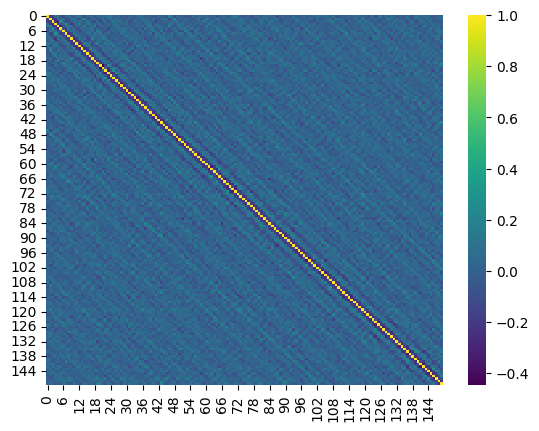

In [200]:
sns.heatmap(data.drop(columns='defect').corr(), cmap='viridis');

In [201]:
data

,defect,0,1,2,3,4,5,6,7,8,...,140,141,142,143,144,145,146,147,148,149
0,eccentricity,3.504435,3.494779,3.485638,3.495640,3.503114,3.498199,3.505385,3.505472,3.502048,...,3.498815,3.506388,3.509104,3.505078,3.501001,3.502236,3.500080,3.495453,3.498027,3.509534
1,eccentricity,3.502259,3.506170,3.498193,3.510379,3.504031,3.499812,3.496883,3.504083,3.493529,...,3.499609,3.502387,3.499010,3.510646,3.506992,3.497876,3.495607,3.511929,3.505708,3.493130
2,eccentricity,3.505875,3.492733,3.494035,3.504544,3.506749,3.485807,3.511464,3.504690,3.502895,...,3.508092,3.491469,3.505895,3.498016,3.504922,3.504723,3.498259,3.495972,3.506910,3.499173
3,eccentricity,3.504302,3.488220,3.498263,3.513143,3.496356,3.507966,3.509298,3.508247,3.493025,...,3.505872,3.514388,3.507682,3.496287,3.498335,3.521109,3.501379,3.493224,3.484623,3.493331
4,eccentricity,3.506712,3.483381,3.486126,3.502397,3.503985,3.510024,3.487461,3.504806,3.502426,...,3.494351,3.513777,3.500205,3.499108,3.498492,3.494042,3.500851,3.505945,3.506432,3.502667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.516581,3.470333,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734
992,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.503270,3.473632,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246
993,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.498361,3.530928,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261
994,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.489856,3.507756,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658


In [202]:
X = data.drop(columns='defect')
y = data['defect']

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

In [204]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8)

In [205]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 3, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1,
        'device': 'gpu'
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy

In [206]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-03-31 19:55:01,919] A new study created in memory with name: no-name-a6d06154-1ddf-40d0-917f-f74cd6a56e3c
[I 2024-03-31 19:55:02,514] Trial 0 finished with value: 0.31875 and parameters: {'learning_rate': 1.6022940375346602, 'num_leaves': 2020, 'reg_lambda': 0.5282496238599753, 'reg_alpha': 0.3107357329198329, 'min_child_samples': 92}. Best is trial 0 with value: 0.31875.
[I 2024-03-31 19:55:03,201] Trial 1 finished with value: 0.53125 and parameters: {'learning_rate': 0.415276932163583, 'num_leaves': 2002, 'reg_lambda': 0.7538033436651881, 'reg_alpha': 0.9998195613544703, 'min_child_samples': 54}. Best is trial 1 with value: 0.53125.
[I 2024-03-31 19:55:03,722] Trial 2 finished with value: 0.3625 and parameters: {'learning_rate': 1.8667333543943236, 'num_leaves': 190, 'reg_lambda': 0.9203747399212605, 'reg_alpha': 0.041909585306044383, 'min_child_samples': 19}. Best is trial 1 with value: 0.53125.
[I 2024-03-31 19:55:04,133] Trial 3 finished with value: 0.5 and parameters: {'l

[I 2024-03-31 19:56:08,205] Trial 31 finished with value: 0.51875 and parameters: {'learning_rate': 0.15770534660754776, 'num_leaves': 1281, 'reg_lambda': 0.491621794853456, 'reg_alpha': 0.9129487354639718, 'min_child_samples': 40}. Best is trial 21 with value: 0.56875.
[I 2024-03-31 19:56:09,807] Trial 32 finished with value: 0.48125 and parameters: {'learning_rate': 0.3860620917453004, 'num_leaves': 2204, 'reg_lambda': 0.6334731499843617, 'reg_alpha': 0.8582401939021815, 'min_child_samples': 23}. Best is trial 21 with value: 0.56875.
[I 2024-03-31 19:56:11,103] Trial 33 finished with value: 0.525 and parameters: {'learning_rate': 0.26312392310244426, 'num_leaves': 578, 'reg_lambda': 0.5403551123142483, 'reg_alpha': 0.928788662014212, 'min_child_samples': 45}. Best is trial 21 with value: 0.56875.
[I 2024-03-31 19:56:12,325] Trial 34 finished with value: 0.525 and parameters: {'learning_rate': 0.45644349410620966, 'num_leaves': 1813, 'reg_lambda': 0.6639434568529847, 'reg_alpha': 0.77

In [207]:
clf = LGBMClassifier(verbose=-1, **study.best_params)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)

In [208]:
accuracy

0.505

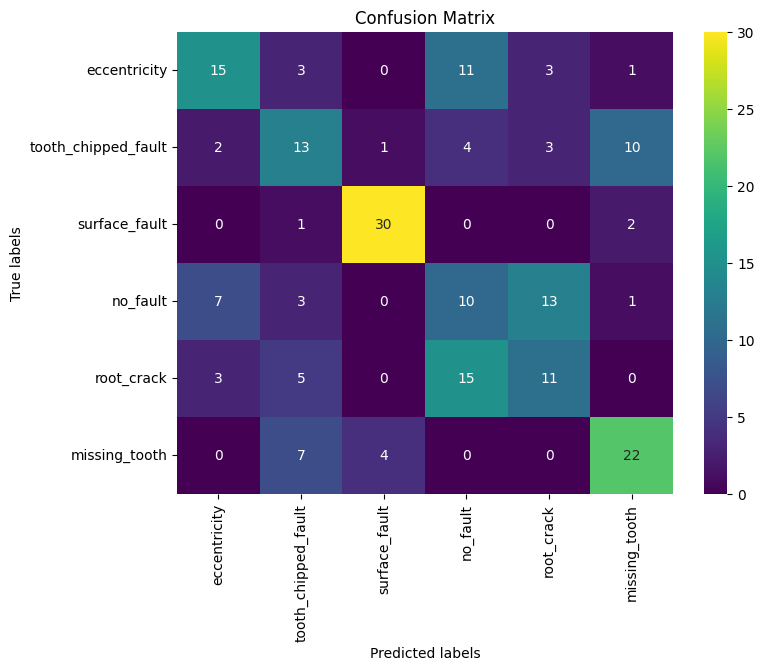

In [209]:
labels = y_test.unique()
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [210]:
data = do_rfft_features(data)
data

,defect,0,1,2,3,4,5,6,7,8,...,66,67,68,69,70,71,72,73,74,75
0,eccentricity,525.300361,0.086251,0.064651,0.055709,0.043706,0.010399,0.103271,0.063116,0.107198,...,0.121369,0.017566,0.104780,0.062854,0.094239,0.057732,0.143755,0.179617,0.116678,0.155595
1,eccentricity,525.320228,0.096307,0.057703,0.065439,0.133730,0.086274,0.066657,0.029748,0.065393,...,0.134684,0.016750,0.073367,0.078766,0.061663,0.108380,0.117978,0.076330,0.068246,0.019819
2,eccentricity,525.290372,0.091189,0.041980,0.123393,0.072537,0.086720,0.108318,0.110195,0.095946,...,0.087457,0.052120,0.066383,0.148948,0.126035,0.218994,0.073965,0.042056,0.146307,0.034748
3,eccentricity,525.345796,0.051117,0.097616,0.082396,0.058996,0.025688,0.052397,0.013755,0.056942,...,0.075010,0.082815,0.018996,0.105550,0.112784,0.033298,0.119713,0.132907,0.015622,0.092434
4,eccentricity,525.055274,0.031709,0.104373,0.048793,0.069053,0.008650,0.103812,0.141121,0.052631,...,0.084934,0.100817,0.060511,0.079020,0.084821,0.163684,0.069359,0.114985,0.075826,0.097065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,tooth_chipped_fault,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.300126,0.185319,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838
992,tooth_chipped_fault,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.115612,0.256963,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946
993,tooth_chipped_fault,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.057819,0.127003,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090
994,tooth_chipped_fault,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.267125,0.161924,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863


In [211]:
data['defect'].value_counts()

defect
eccentricity           166
missing_tooth          166
no_fault               166
root_crack             166
surface_fault          166
tooth_chipped_fault    166
Name: count, dtype: int64

<Axes: >

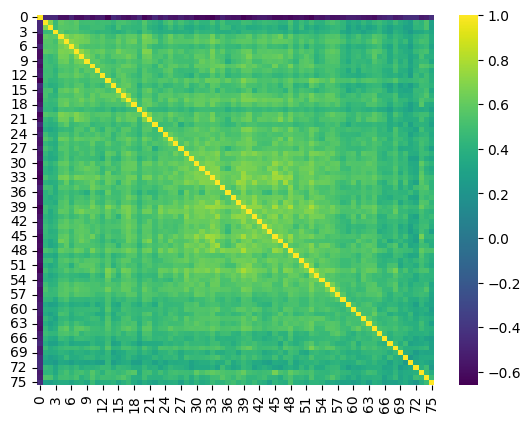

In [212]:
sns.heatmap(data.drop(columns='defect').corr(), cmap='viridis')

In [213]:
X = data.drop(columns='defect')
y = data['defect']

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

In [215]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8)

In [216]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 3, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1,
        'device': 'gpu'
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy
    

In [217]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-03-31 19:57:28,415] A new study created in memory with name: no-name-5730c38d-cf2c-47ef-a042-a894c418eb97
[I 2024-03-31 19:57:28,692] Trial 0 finished with value: 0.90625 and parameters: {'learning_rate': 1.3970524086500318, 'num_leaves': 1627, 'reg_lambda': 0.3088644344982989, 'reg_alpha': 0.8206928502362464, 'min_child_samples': 88}. Best is trial 0 with value: 0.90625.
[I 2024-03-31 19:57:29,075] Trial 1 finished with value: 0.90625 and parameters: {'learning_rate': 1.5944034922204293, 'num_leaves': 3369, 'reg_lambda': 0.28926563149499684, 'reg_alpha': 0.32545962270697404, 'min_child_samples': 50}. Best is trial 0 with value: 0.90625.
[I 2024-03-31 19:57:29,399] Trial 2 finished with value: 0.7125 and parameters: {'learning_rate': 1.8093326794870954, 'num_leaves': 1773, 'reg_lambda': 0.12364075272257802, 'reg_alpha': 0.24920709018654963, 'min_child_samples': 54}. Best is trial 0 with value: 0.90625.
[I 2024-03-31 19:57:29,627] Trial 3 finished with value: 0.94375 and paramet

[I 2024-03-31 19:57:50,684] Trial 30 finished with value: 0.95 and parameters: {'learning_rate': 0.3017336939181925, 'num_leaves': 1418, 'reg_lambda': 0.27208277085001165, 'reg_alpha': 0.5511115758768179, 'min_child_samples': 85}. Best is trial 15 with value: 0.96875.
[I 2024-03-31 19:57:51,607] Trial 31 finished with value: 0.95 and parameters: {'learning_rate': 0.3865166369331404, 'num_leaves': 3270, 'reg_lambda': 0.0072341393104564215, 'reg_alpha': 0.49799676828497275, 'min_child_samples': 64}. Best is trial 15 with value: 0.96875.
[I 2024-03-31 19:57:52,697] Trial 32 finished with value: 0.95625 and parameters: {'learning_rate': 0.3024804713591788, 'num_leaves': 3718, 'reg_lambda': 0.06468373423468274, 'reg_alpha': 0.5849204015207409, 'min_child_samples': 74}. Best is trial 15 with value: 0.96875.
[I 2024-03-31 19:57:53,539] Trial 33 finished with value: 0.95625 and parameters: {'learning_rate': 0.14756257588006255, 'num_leaves': 411, 'reg_lambda': 0.20194848457432094, 'reg_alpha':

In [218]:
print(study.best_params)

{'learning_rate': 0.33314124098439085, 'num_leaves': 2701, 'reg_lambda': 0.000655353478715405, 'reg_alpha': 0.18893932668519314, 'min_child_samples': 63}


In [219]:
best_params = {'learning_rate': 0.8814586632393469, 'num_leaves': 2290, 'reg_lambda': 0.9668567222949773, 'min_child_samples': 76}

In [220]:
clf = LGBMClassifier(verbose=-1, **study.best_params)

clf.fit(X_train, y_train)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)

In [221]:
accuracy

0.98

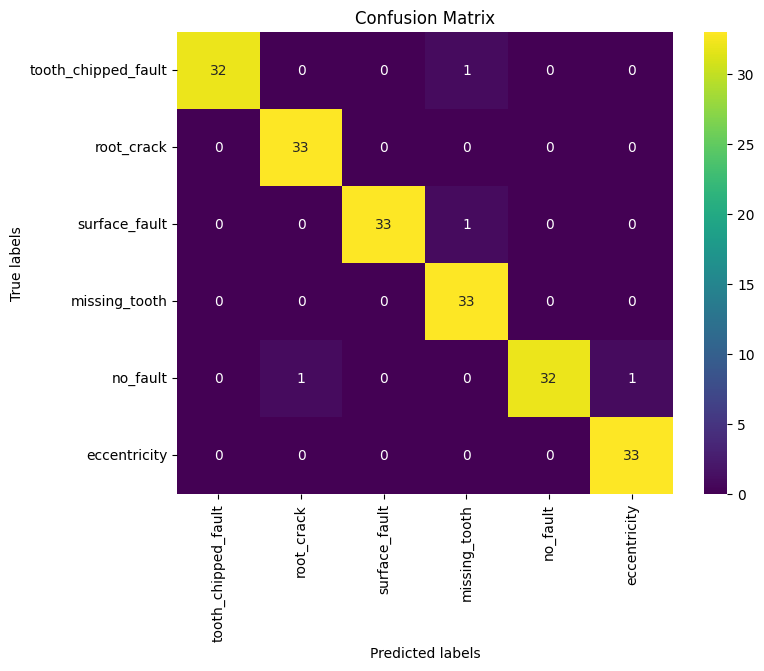

In [222]:
labels = y_test.unique()
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [223]:
vel_list = [8.33203125, 25.0, 40.0]
data_eccentricity = read_data_and_choose('eccentricity.csv', velocity=vel_list[0], load=False)
eccentricity_time = data_eccentricity['time']
eccentricity_disp = data_eccentricity['displacements']
data_eccentricity

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.522315,2.431974,3.503794,8.332031,0,eccentricity
1,0.0002,2.523629,2.431317,3.504284,8.332031,0,eccentricity
2,0.0004,2.522644,2.428032,3.501296,8.332031,0,eccentricity
3,0.0006,2.521987,2.430660,3.502646,8.332031,0,eccentricity
4,0.0008,2.522808,2.430168,3.502895,8.332031,0,eccentricity
...,...,...,...,...,...,...,...
24995,4.9990,2.522479,2.431153,3.503342,8.332031,0,eccentricity
24996,4.9992,2.520180,2.432631,3.502713,8.332031,0,eccentricity
24997,4.9994,2.522644,2.427704,3.501068,8.332031,0,eccentricity
24998,4.9996,2.524286,2.430496,3.504188,8.332031,0,eccentricity


In [224]:
data_missing_tooth = read_data_and_choose('missing_tooth.csv', velocity=vel_list[0], load=False)
missing_tooth_time = data_missing_tooth['time']
missing_tooth_disp = data_missing_tooth['displacements']
data_missing_tooth

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.520016,2.430496,3.501113,8.332031,0,missing tooth
1,0.0002,2.521822,2.430660,3.502527,8.332031,0,missing tooth
2,0.0004,2.519194,2.429511,3.499837,8.332031,0,missing tooth
3,0.0006,2.519851,2.428853,3.499854,8.332031,0,missing tooth
4,0.0008,2.518701,2.429346,3.499369,8.332031,0,missing tooth
...,...,...,...,...,...,...,...
24995,4.9990,2.519851,2.430168,3.500766,8.332031,0,missing tooth
24996,4.9992,2.520673,2.429018,3.500560,8.332031,0,missing tooth
24997,4.9994,2.519358,2.428032,3.498930,8.332031,0,missing tooth
24998,4.9996,2.520508,2.428689,3.500213,8.332031,0,missing tooth


In [225]:
data_no_fault = read_data_and_choose('no_fault.csv', velocity=vel_list[0], load=False)
no_fault_time = data_no_fault['time']
no_fault_disp = data_no_fault['displacements']
data_no_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.523465,2.430168,3.503368,8.332031,0,No fault
1,0.0002,2.521494,2.430003,3.501835,8.332031,0,No fault
2,0.0004,2.522479,2.429675,3.502317,8.332031,0,No fault
3,0.0006,2.521330,2.431810,3.502971,8.332031,0,No fault
4,0.0008,2.522479,2.431317,3.503456,8.332031,0,No fault
...,...,...,...,...,...,...,...
24995,4.9990,2.520508,2.429839,3.501011,8.332031,0,No fault
24996,4.9992,2.520016,2.431153,3.501569,8.332031,0,No fault
24997,4.9994,2.520837,2.429839,3.501248,8.332031,0,No fault
24998,4.9996,2.521165,2.432960,3.503651,8.332031,0,No fault


In [226]:
data_root_crack = read_data_and_choose('root_crack.csv', velocity=vel_list[0], load=False)
root_crack_time = data_root_crack['time']
root_crack_disp = data_root_crack['displacements']
data_root_crack

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.519358,2.429675,3.500070,8.332031,0,Root crack
1,0.0002,2.519358,2.429839,3.500184,8.332031,0,Root crack
2,0.0004,2.521165,2.430496,3.501940,8.332031,0,Root crack
3,0.0006,2.520508,2.428853,3.500327,8.332031,0,Root crack
4,0.0008,2.519358,2.428689,3.499385,8.332031,0,Root crack
...,...,...,...,...,...,...,...
24995,4.9990,2.521494,2.429839,3.501721,8.332031,0,Root crack
24996,4.9992,2.520837,2.430496,3.501704,8.332031,0,Root crack
24997,4.9994,2.520837,2.429839,3.501248,8.332031,0,Root crack
24998,4.9996,2.520837,2.429182,3.500792,8.332031,0,Root crack


In [227]:
data_surface_fault = read_data_and_choose('surface_fault.csv', velocity=vel_list[0], load=False)
surface_fault_time = data_surface_fault['time']
surface_fault_disp = data_surface_fault['displacements']
data_surface_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.521001,2.427539,3.499771,8.332031,0,surface defect
1,0.0002,2.519851,2.428196,3.499398,8.332031,0,surface defect
2,0.0004,2.520016,2.426225,3.498149,8.332031,0,surface defect
3,0.0006,2.520016,2.428689,3.499859,8.332031,0,surface defect
4,0.0008,2.521165,2.427047,3.499547,8.332031,0,surface defect
...,...,...,...,...,...,...,...
24995,4.9990,2.515581,2.430989,3.498264,8.332031,0,surface defect
24996,4.9992,2.491928,2.441173,3.488413,8.332031,0,surface defect
24997,4.9994,2.545804,2.416206,3.509867,8.332031,0,surface defect
24998,4.9996,2.518537,2.439694,3.506442,8.332031,0,surface defect


In [228]:
data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv', velocity=vel_list[0], load=False)
tooth_chipped_fault_time = data_tooth_chipped_fault['time']
tooth_chipped_fault_disp = data_tooth_chipped_fault['displacements']
data_tooth_chipped_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
0,0.0000,2.518209,2.430496,3.499812,8.332031,0,chipped tooth
1,0.0002,2.517880,2.429839,3.499120,8.332031,0,chipped tooth
2,0.0004,2.516402,2.427211,3.496231,8.332031,0,chipped tooth
3,0.0006,2.518537,2.427704,3.498110,8.332031,0,chipped tooth
4,0.0008,2.518701,2.427539,3.498114,8.332031,0,chipped tooth
...,...,...,...,...,...,...,...
24995,4.9990,2.516895,2.428361,3.497384,8.332031,0,chipped tooth
24996,4.9992,2.519030,2.429018,3.499377,8.332031,0,chipped tooth
24997,4.9994,2.519030,2.426882,3.497895,8.332031,0,chipped tooth
24998,4.9996,2.518209,2.430003,3.499470,8.332031,0,chipped tooth


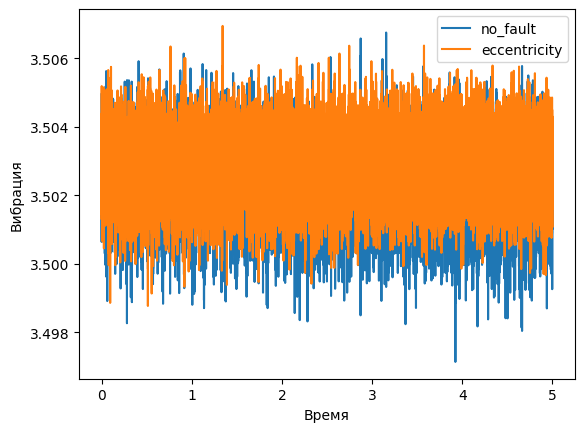

In [229]:
plt.plot(no_fault_time, no_fault_disp, label='no_fault')
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

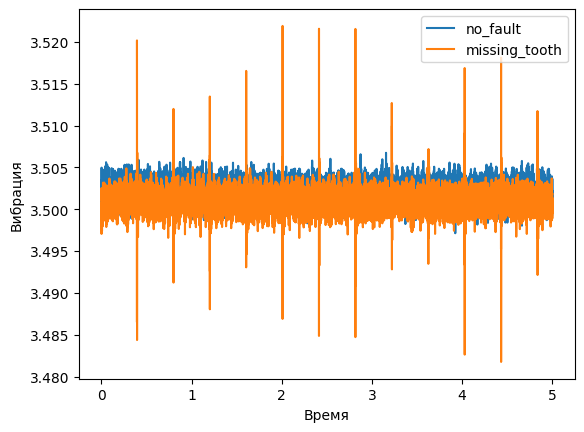

In [230]:
plt.plot(no_fault_time, no_fault_disp, label='no_fault')
plt.plot(missing_tooth_time, missing_tooth_disp, label='missing_tooth')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

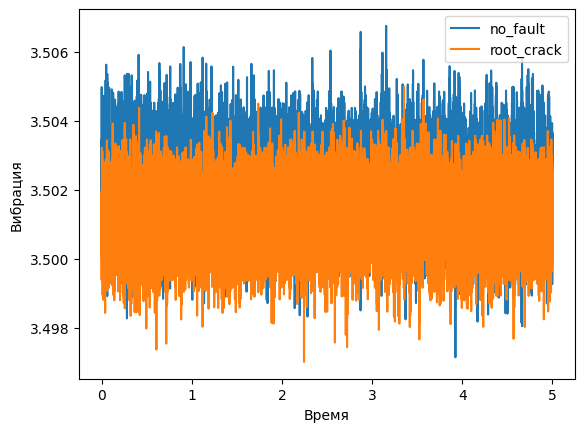

In [231]:
plt.plot(no_fault_time, no_fault_disp, label='no_fault')
plt.plot(root_crack_time, root_crack_disp, label='root_crack')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

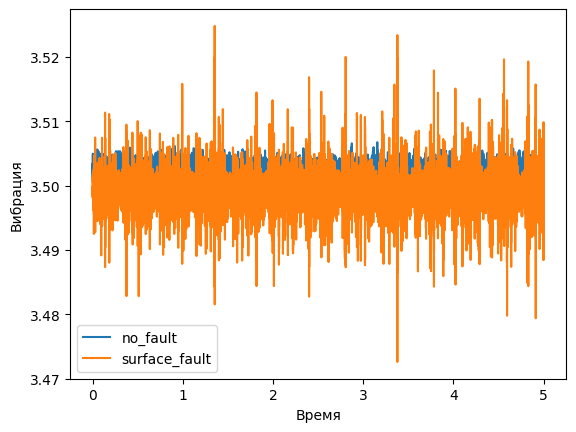

In [232]:
plt.plot(no_fault_time, no_fault_disp, label='no_fault')
plt.plot(surface_fault_time, surface_fault_disp, label='surface_fault')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

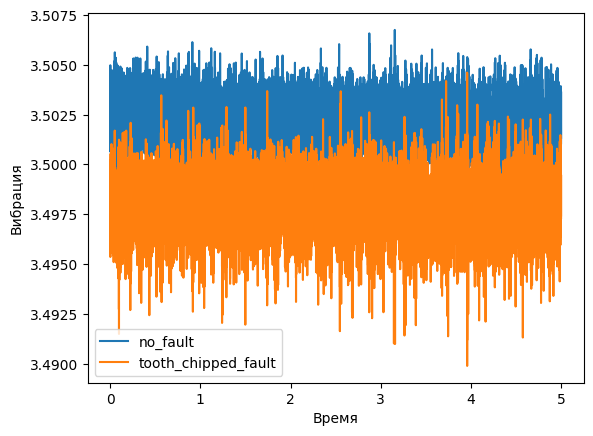

In [233]:
plt.plot(no_fault_time, no_fault_disp, label='no_fault')
plt.plot(tooth_chipped_fault_time, tooth_chipped_fault_disp, label='tooth_chipped_fault')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

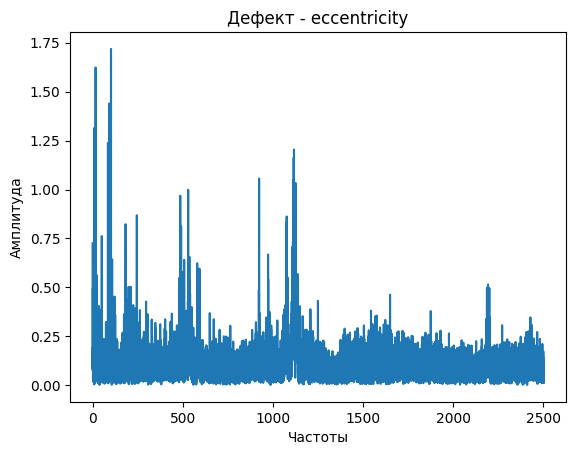

In [234]:
yf = rfft(eccentricity_disp.values)
xf = rfftfreq(n=eccentricity_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - eccentricity')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

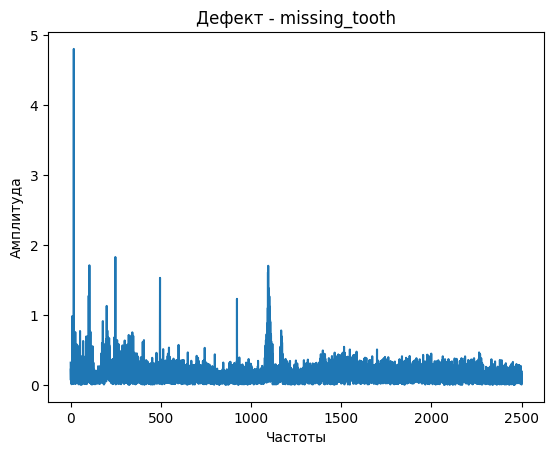

In [235]:
yf = rfft(missing_tooth_disp.values)
xf = rfftfreq(n=missing_tooth_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - missing_tooth')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

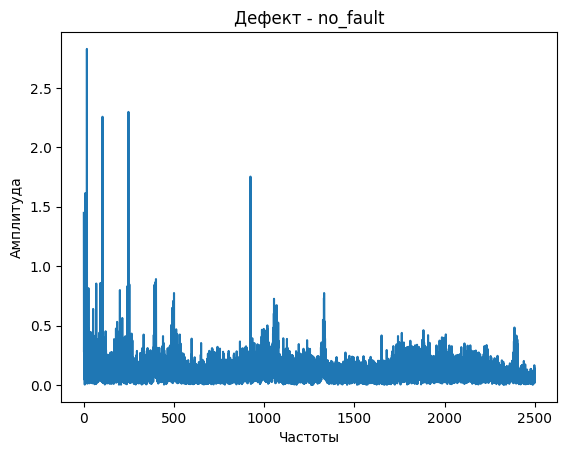

In [236]:
yf = rfft(no_fault_disp.values)
xf = rfftfreq(n=no_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - no_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

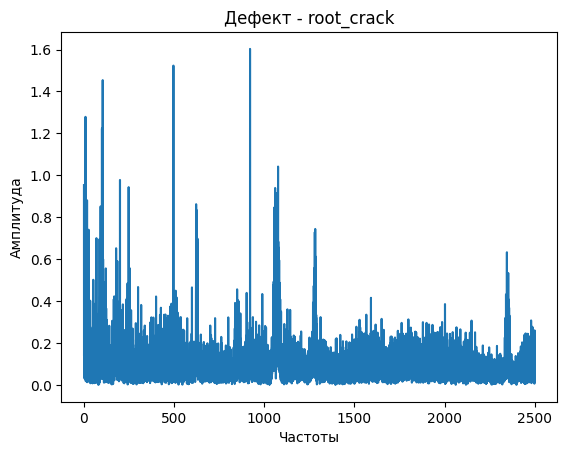

In [237]:
yf = rfft(root_crack_disp.values)
xf = rfftfreq(n=root_crack_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - root_crack')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

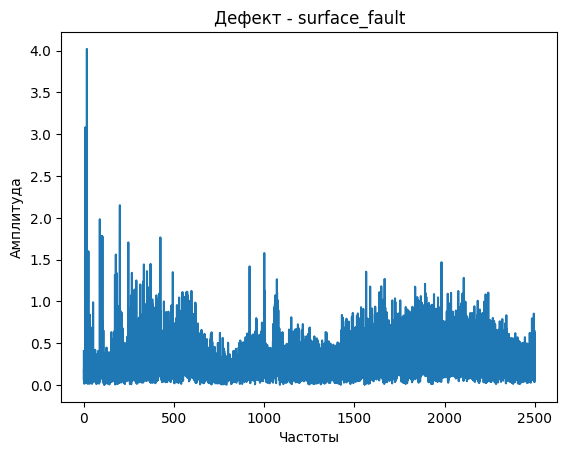

In [238]:
yf = rfft(surface_fault_disp.values)
xf = rfftfreq(n=surface_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - surface_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

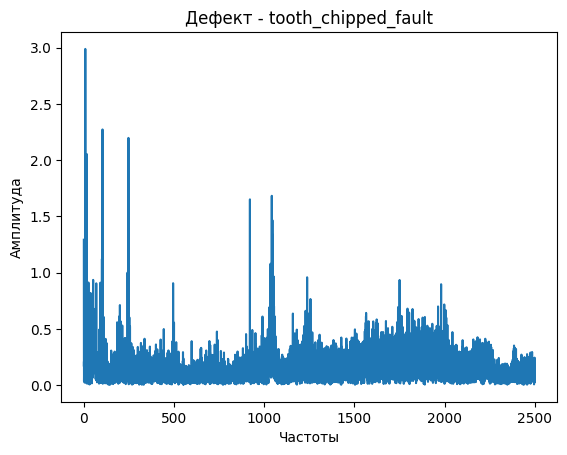

In [239]:
yf = rfft(tooth_chipped_fault_disp.values)
xf = rfftfreq(n=tooth_chipped_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - tooth_chipped_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

## Все данные

In [240]:
big_data = get_all_features_and_targets(n_cols=150, do_fft=True)
big_data

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,eccentricity,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824,8.332031,0.0
1,eccentricity,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188,8.332031,0.0
2,eccentricity,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833,8.332031,0.0
3,eccentricity,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565,8.332031,0.0
4,eccentricity,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838,40.000000,1.0
5972,tooth_chipped_fault,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946,40.000000,1.0
5973,tooth_chipped_fault,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090,40.000000,1.0
5974,tooth_chipped_fault,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863,40.000000,1.0


In [241]:
X = big_data.drop(columns='defect')
y = big_data['defect']

In [242]:
cat_cols = ['velocity', 'load']

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

In [244]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8)

In [245]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train, categorical_feature=cat_cols)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy
    

In [246]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=100)

[I 2024-03-31 19:59:27,272] A new study created in memory with name: no-name-0033714a-fd21-432a-9615-0355456a9283
[I 2024-03-31 19:59:27,673] Trial 0 finished with value: 0.9163179916317992 and parameters: {'learning_rate': 1.152689420133609, 'num_leaves': 3528, 'reg_lambda': 0.3134913373643109, 'reg_alpha': 0.21441321985328987, 'min_child_samples': 90}. Best is trial 0 with value: 0.9163179916317992.
[I 2024-03-31 19:59:28,459] Trial 1 finished with value: 0.7782426778242678 and parameters: {'learning_rate': 1.3755939887259085, 'num_leaves': 3808, 'reg_lambda': 0.4682836290034663, 'reg_alpha': 0.3554823282212034, 'min_child_samples': 41}. Best is trial 0 with value: 0.9163179916317992.
[I 2024-03-31 19:59:29,197] Trial 2 finished with value: 0.9456066945606695 and parameters: {'learning_rate': 0.17725181301245163, 'num_leaves': 1673, 'reg_lambda': 0.06156124383865336, 'reg_alpha': 0.11573733174910628, 'min_child_samples': 62}. Best is trial 2 with value: 0.9456066945606695.
[I 2024-03

[I 2024-03-31 20:00:00,632] Trial 28 finished with value: 0.9351464435146444 and parameters: {'learning_rate': 0.6440453702945259, 'num_leaves': 3595, 'reg_lambda': 0.10547497153196583, 'reg_alpha': 0.07809160790074283, 'min_child_samples': 22}. Best is trial 11 with value: 0.9539748953974896.
[I 2024-03-31 20:00:01,680] Trial 29 finished with value: 0.944560669456067 and parameters: {'learning_rate': 0.38143627886009984, 'num_leaves': 2885, 'reg_lambda': 0.3107876817441654, 'reg_alpha': 0.19584303272357625, 'min_child_samples': 48}. Best is trial 11 with value: 0.9539748953974896.
[I 2024-03-31 20:00:03,715] Trial 30 finished with value: 0.9476987447698745 and parameters: {'learning_rate': 0.10919593430240337, 'num_leaves': 1985, 'reg_lambda': 0.17958143479467656, 'reg_alpha': 0.0035757282038079152, 'min_child_samples': 32}. Best is trial 11 with value: 0.9539748953974896.
[I 2024-03-31 20:00:05,472] Trial 31 finished with value: 0.9476987447698745 and parameters: {'learning_rate': 0.

[I 2024-03-31 20:00:39,674] Trial 56 finished with value: 0.9414225941422594 and parameters: {'learning_rate': 0.46518728141032795, 'num_leaves': 2125, 'reg_lambda': 0.08555992254731501, 'reg_alpha': 0.026233398953307653, 'min_child_samples': 98}. Best is trial 11 with value: 0.9539748953974896.
[I 2024-03-31 20:00:40,791] Trial 57 finished with value: 0.9539748953974896 and parameters: {'learning_rate': 0.23018966301860805, 'num_leaves': 2937, 'reg_lambda': 0.0364789763265036, 'reg_alpha': 0.150563900807883, 'min_child_samples': 80}. Best is trial 11 with value: 0.9539748953974896.
[I 2024-03-31 20:00:41,688] Trial 58 finished with value: 0.9497907949790795 and parameters: {'learning_rate': 0.40377653231148625, 'num_leaves': 2964, 'reg_lambda': 0.04009149702833603, 'reg_alpha': 0.15279152197806672, 'min_child_samples': 82}. Best is trial 11 with value: 0.9539748953974896.
[I 2024-03-31 20:00:42,915] Trial 59 finished with value: 0.9518828451882845 and parameters: {'learning_rate': 0.2

In [250]:
clf = LGBMClassifier(verbose=-1, **study.best_params)

clf.fit(X_train, y_train, categorical_feature=cat_cols)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)

In [251]:
accuracy

0.9548494983277592

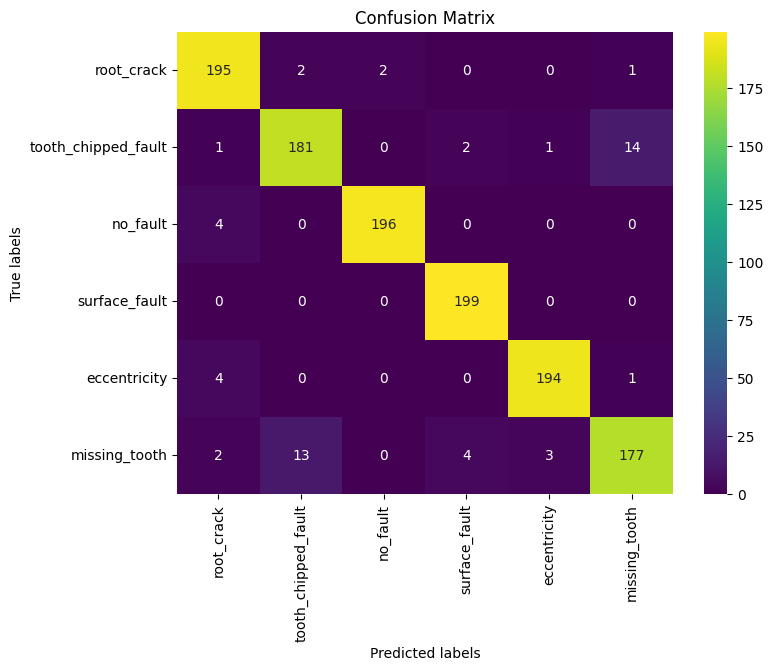

In [252]:
labels = y_test.unique()
cm = confusion_matrix(y_test, preds, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Torch

In [253]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [254]:
class Custom_Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, scale_num: bool, OHE: bool):
        if scale_num:
            num_cols = df.drop(columns=['defect', 'velocity', 'load']).columns
            scaler = StandardScaler()
            df[num_cols] = scaler.fit_transform(df[num_cols])
        if OHE:
            df = pd.get_dummies(df, columns=['velocity', 'load'], dtype=int)
        self.df = df
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        feature = self.df.drop(columns='defect').values
        feature = np.array(feature, dtype=np.float32)
        label = self.df['defect'].values
        label = np.array(label, dtype=np.int32)
        return feature[idx, :], label[idx]

In [255]:
label_enc = LabelEncoder()
big_data['defect'] = label_enc.fit_transform(big_data['defect'])
big_data

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,0,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824,8.332031,0.0
1,0,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188,8.332031,0.0
2,0,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833,8.332031,0.0
3,0,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565,8.332031,0.0
4,0,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,5,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838,40.000000,1.0
5972,5,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946,40.000000,1.0
5973,5,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090,40.000000,1.0
5974,5,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863,40.000000,1.0


In [256]:
df_train, df_test = train_test_split(big_data, train_size=0.7, stratify=big_data['defect'])

In [257]:
df_test

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
3189,1,524.992494,0.011520,0.046595,0.045912,0.048043,0.036238,0.034638,0.066567,0.250196,...,0.158543,0.127717,0.075988,0.052203,0.019489,0.008866,0.009943,0.080408,25.000000,1.0
868,5,524.701168,0.030377,0.011423,0.009636,0.008802,0.008814,0.016759,0.006499,0.001163,...,0.010821,0.011199,0.007540,0.004867,0.014130,0.011646,0.009078,0.010591,8.332031,0.0
505,3,525.170582,0.001541,0.012211,0.027976,0.017825,0.019858,0.014324,0.003008,0.005571,...,0.008969,0.002039,0.010261,0.011522,0.010997,0.002392,0.010926,0.006491,8.332031,0.0
580,3,525.168103,0.017966,0.017360,0.025084,0.002766,0.004813,0.017700,0.005829,0.006435,...,0.000853,0.002132,0.011384,0.014908,0.001683,0.010692,0.004798,0.019052,8.332031,0.0
5033,0,525.292536,0.044187,0.162945,0.036289,0.064351,0.059826,0.091115,0.020638,0.088680,...,0.115893,0.126815,0.203666,0.243082,0.118429,0.031700,0.061843,0.110085,40.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2416,2,524.536292,0.021813,0.029511,0.040955,0.058887,0.017935,0.042444,0.009428,0.039726,...,0.072649,0.032436,0.039532,0.010096,0.049459,0.023211,0.038674,0.036126,25.000000,0.0
3683,4,524.589801,0.088400,0.104617,0.071855,0.050050,0.106546,0.127527,0.069596,0.398728,...,0.376868,0.183220,0.206766,0.318341,0.185345,0.216311,0.202525,0.106345,25.000000,1.0
3000,0,524.998617,0.014652,0.015701,0.030808,0.032951,0.033405,0.028336,0.049692,0.145217,...,0.037163,0.008279,0.029373,0.057518,0.030084,0.051730,0.062799,0.030978,25.000000,1.0
5550,3,525.379544,0.015334,0.033813,0.031457,0.148803,0.066286,0.041737,0.013923,0.051309,...,0.222922,0.129329,0.085475,0.319985,0.083211,0.246231,0.162213,0.019033,40.000000,1.0


In [258]:
df_train

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
4423,2,525.634994,0.129194,0.054962,0.049686,0.078887,0.047891,0.131893,0.112135,0.026857,...,0.121022,0.056089,0.069232,0.083240,0.054664,0.068210,0.079165,0.009857,40.000000,0.0
3032,0,525.009400,0.021075,0.055108,0.074497,0.037368,0.040850,0.018117,0.044092,0.165112,...,0.068469,0.113070,0.083578,0.037662,0.031012,0.025187,0.050790,0.020847,25.000000,1.0
5266,1,524.455718,0.100920,0.116934,0.090531,0.082685,0.103626,0.031078,0.023667,0.079864,...,0.230737,0.312789,0.369906,0.293856,0.182499,0.187106,0.074301,0.164960,40.000000,1.0
319,1,525.137759,0.013274,0.012428,0.034328,0.011072,0.004583,0.036014,0.008710,0.014702,...,0.004403,0.004802,0.001176,0.006406,0.011019,0.008213,0.005249,0.009912,8.332031,0.0
4321,2,525.590554,0.129420,0.079064,0.101496,0.103020,0.137638,0.113514,0.033159,0.040048,...,0.033537,0.038052,0.027113,0.051859,0.026396,0.086426,0.096129,0.001136,40.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5966,5,525.075101,0.048881,0.038926,0.114994,0.074457,0.050622,0.017233,0.097193,0.044010,...,0.107528,0.132585,0.275725,0.456929,0.164529,0.062080,0.062099,0.069273,40.000000,1.0
5523,3,525.540325,0.046970,0.075877,0.160896,0.136769,0.072206,0.053526,0.054310,0.037179,...,0.088409,0.231001,0.354045,0.213869,0.082397,0.107799,0.012892,0.057590,40.000000,1.0
1835,5,525.133483,0.030477,0.012427,0.005148,0.009039,0.011101,0.011522,0.021790,0.037039,...,0.002348,0.007047,0.008139,0.007227,0.007360,0.006795,0.006527,0.004770,8.332031,1.0
4945,5,524.720158,0.024756,0.101196,0.086199,0.008083,0.010972,0.055075,0.086294,0.031108,...,0.084520,0.068329,0.096704,0.061310,0.063303,0.087387,0.084286,0.041046,40.000000,0.0


In [259]:
train_dataset = Custom_Dataset(df_train, scale_num=True, OHE=True)
test_dataset = Custom_Dataset(df_test, scale_num=True, OHE=True)

In [260]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [261]:
class Net(nn.Module):
    def __init__(self):        
        super(Net, self).__init__() 
         
        self.fc1 = nn.Linear(81, 100)
        self.do1 = nn.Dropout(0.33)
        self.fc2 = nn.Linear(100, 6)
          
    def forward(self, x):                        
        x = self.fc1(x)                         
        x = nn.ReLU()(x)
        x = self.do1(x)
        x = self.fc2(x)
        return x
          
model = Net()               

In [262]:
criterion = torch.nn.CrossEntropyLoss()
optimezer = torch.optim.Adam(params=model.parameters(), lr=0.1)
scheduler = lr_scheduler.ExponentialLR(optimezer, gamma=0.5)

In [263]:
epochs = 10
model.to(device)
train_loss_values = []
test_loss_values = []
train_accuracy = []
test_accuracy = []
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for i, (X_train, label) in enumerate(train_dataloader):
        X_train = X_train.to(device)
        label = label.to(device).long()
        optimezer.zero_grad()
        prediction = model(X_train)
        _, predictions = torch.max(prediction.data, 1)
        loss = criterion(prediction, label)
        loss.backward()
        optimezer.step()
        running_loss += loss.item()
        total += label.size(0)
        correct += (predictions == label).sum().item()
    print(f'Epoch №{epoch + 1}, Training loss = {running_loss / len(train_dataloader)}')
    print(f'Epoch №{epoch + 1}, Accuracy on train = {correct / total * 100}%')
    train_loss_values.append(running_loss / len(train_dataloader))
    train_accuracy.append(correct / total * 100)
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        model.eval()
        for X_val, label_val in test_dataloader:
            X_val = X_val.to(device)
            label_val = label_val.to(device).long()
            outputs = model(X_val)
            loss = criterion(outputs, label_val)
            running_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            total += label_val.size(0)
            correct += (predictions == label_val).sum().item()
    scheduler.step()
    print(f'Epoch №{epoch + 1}, Test loss = {running_loss / len(test_dataloader)}')
    print(f'Epoch №{epoch + 1}, Accuracy on test = {correct / total * 100}%')
    test_loss_values.append(running_loss / len(train_dataloader))
    test_accuracy.append(correct / total * 100)
    print('----------------------------------------------------------------')

Epoch №1, Training loss = 3.284368291948781
Epoch №1, Accuracy on train = 46.30647860387282%
Epoch №1, Test loss = 0.9239662606911413
Epoch №1, Accuracy on test = 72.00223089793641%
----------------------------------------------------------------
Epoch №2, Training loss = 0.8659491164214683
Epoch №2, Accuracy on train = 70.66698541716472%
Epoch №2, Test loss = 0.43629973612982653
Epoch №2, Accuracy on test = 85.49916341327383%
----------------------------------------------------------------
Epoch №3, Training loss = 0.6183728194146445
Epoch №3, Accuracy on train = 78.50824766913699%
Epoch №3, Test loss = 0.6151617601000029
Epoch №3, Accuracy on test = 91.2994980479643%
----------------------------------------------------------------
Epoch №4, Training loss = 0.4706185618133256
Epoch №4, Accuracy on train = 82.09419077217308%
Epoch №4, Test loss = 0.3252418601307376
Epoch №4, Accuracy on test = 92.69380925822644%
----------------------------------------------------------------
Epoch №5,

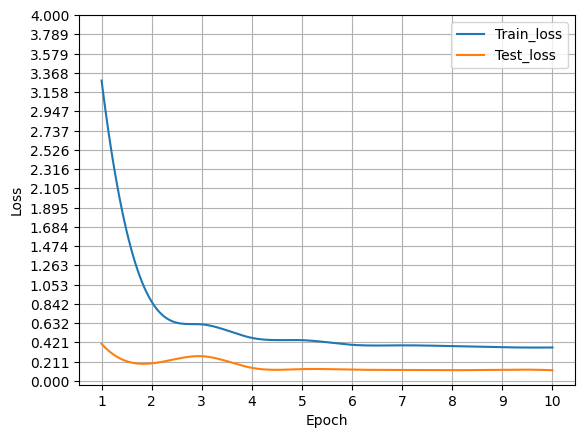

In [269]:
from scipy.interpolate import make_interp_spline, BSpline

#create data
x = np.array([i + 1 for i in range(epochs)])
y1 = np.array(train_loss_values)
y2 = np.array(test_loss_values)
xnew = np.linspace(x.min(), x.max(), 200) 

#define spline
spl1 = make_interp_spline(x, y1, k=3)
y_smooth1 = spl1(xnew)
spl2 = make_interp_spline(x, y2, k=3)
y_smooth2 = spl2(xnew)
#create smooth line chart 
plt.plot(xnew, y_smooth1, label='Train_loss')
plt.plot(xnew, y_smooth2, label='Test_loss')
plt.xticks([i + 1 for i in range(epochs)])
plt.yticks(np.linspace(np.floor(min(train_loss_values + test_loss_values)), np.ceil(max(train_loss_values + test_loss_values)), 20))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

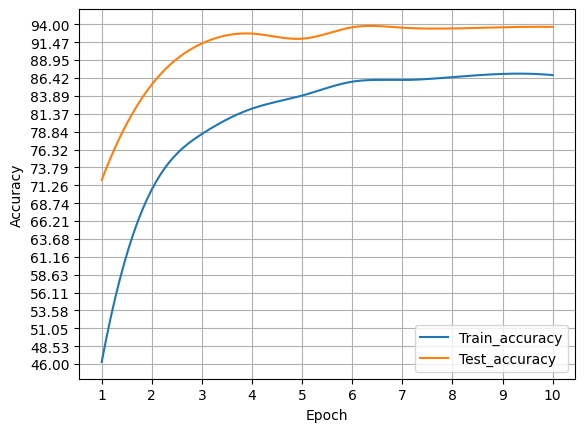

In [270]:
x = np.array([i + 1 for i in range(epochs)])
y1 = np.array(train_accuracy)
y2 = np.array(test_accuracy)
xnew = np.linspace(x.min(), x.max(), 200) 

#define spline
spl1 = make_interp_spline(x, y1, k=3)
y_smooth1 = spl1(xnew)
spl2 = make_interp_spline(x, y2, k=3)
y_smooth2 = spl2(xnew)
#create smooth line chart 
plt.plot(xnew, y_smooth1, label='Train_accuracy')
plt.plot(xnew, y_smooth2, label='Test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([i + 1 for i in range(epochs)])
plt.yticks(np.linspace(np.floor(min(train_accuracy + test_accuracy)), np.ceil(max(train_accuracy + test_accuracy)), 20))
plt.grid()
plt.legend()
plt.show()

In [54]:
big_data = get_all_features_and_targets(n_cols=1000, do_fft=False)

In [55]:
big_data

,defect,0,1,2,3,4,5,6,7,8,...,992,993,994,995,996,997,998,999,velocity,load
0,eccentricity,3.503794,3.504284,3.501296,3.502646,3.502895,3.504385,3.501738,3.501451,3.502886,...,3.501239,3.501345,3.502709,3.504820,3.504381,3.502747,3.502646,3.504854,8.332031,0.0
1,eccentricity,3.502895,3.501510,3.500999,3.501662,3.503309,3.501581,3.501134,3.501936,3.503558,...,3.503575,3.501831,3.503558,3.502181,3.502979,3.504715,3.504048,3.502291,8.332031,0.0
2,eccentricity,3.501375,3.503334,3.503929,3.503680,3.500994,3.503076,3.503947,3.505012,3.503701,...,3.503250,3.502772,3.502265,3.502519,3.502768,3.504175,3.503211,3.503334,8.332031,0.0
3,eccentricity,3.503022,3.503820,3.502059,3.502848,3.502494,3.503807,3.500906,3.503342,3.502878,...,3.501336,3.502983,3.503342,3.503216,3.502734,3.501222,3.502962,3.503465,8.332031,0.0
4,eccentricity,3.502743,3.501016,3.501932,3.502050,3.503474,3.501480,3.502037,3.502624,3.502654,...,3.503558,3.502992,3.502751,3.503465,3.503587,3.504043,3.502658,3.504179,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,tooth_chipped_fault,3.516108,3.490077,3.480503,3.538634,3.493571,3.497568,3.492015,3.505374,3.494644,...,3.497938,3.498709,3.504809,3.505048,3.509413,3.490649,3.516888,3.494272,40.000000,1.0
896,tooth_chipped_fault,3.494186,3.493973,3.484591,3.470970,3.496191,3.486603,3.522058,3.506896,3.513587,...,3.499302,3.500306,3.501734,3.500877,3.482042,3.504534,3.508308,3.490371,40.000000,1.0
897,tooth_chipped_fault,3.500929,3.506697,3.517205,3.524766,3.471116,3.522016,3.501702,3.454824,3.523714,...,3.502803,3.481030,3.507439,3.476587,3.522372,3.495078,3.492686,3.519807,40.000000,1.0
898,tooth_chipped_fault,3.481289,3.522285,3.502751,3.487161,3.537699,3.484394,3.488068,3.517876,3.489490,...,3.510549,3.492386,3.518726,3.484637,3.511213,3.498229,3.509970,3.495729,40.000000,1.0


In [56]:
num_cols = big_data.drop(columns=['defect', 'velocity', 'load']).columns
num_cols

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
      dtype='object', length=1000)

In [57]:
#scaler = StandardScaler()
#big_data[num_cols] = scaler.fit_transform(big_data[num_cols])
#big_data

In [58]:
big_data.defect.unique()

array(['eccentricity', 'missing_tooth', 'no_fault', 'root_crack',
       'surface_fault', 'tooth_chipped_fault'], dtype=object)

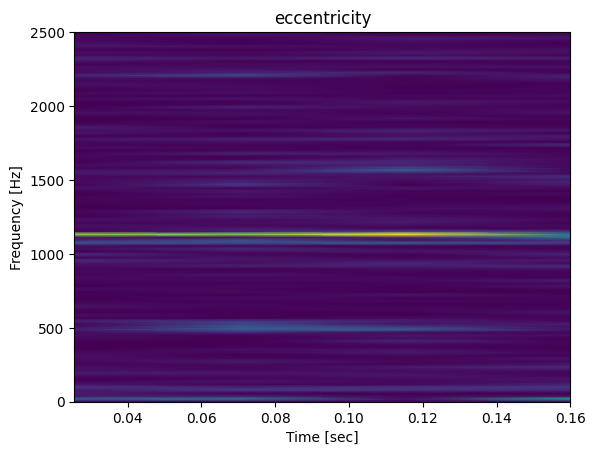

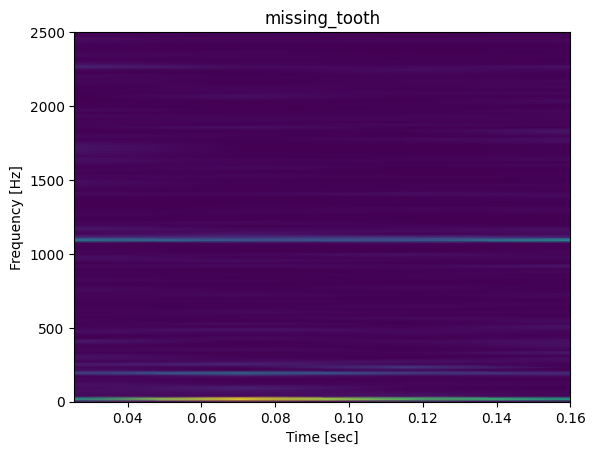

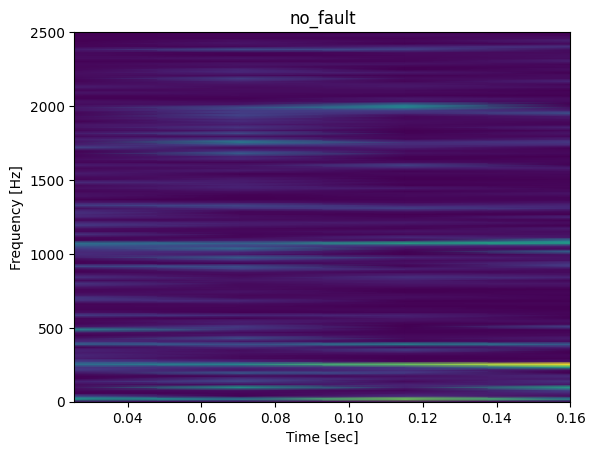

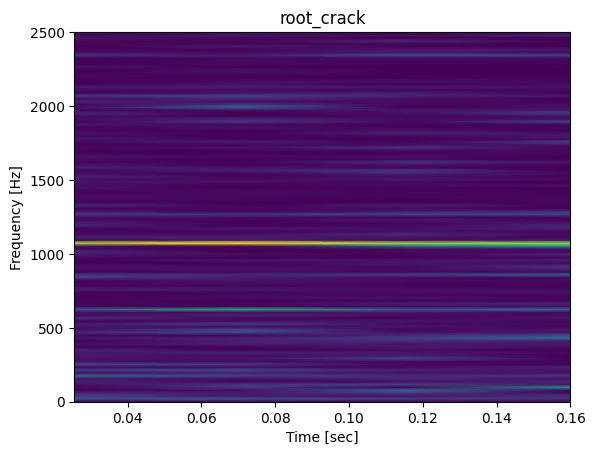

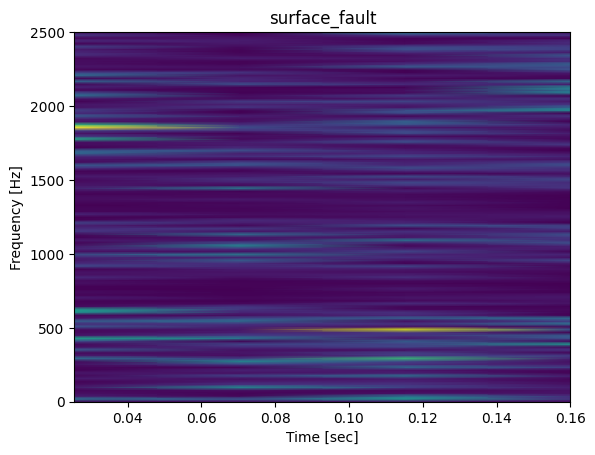

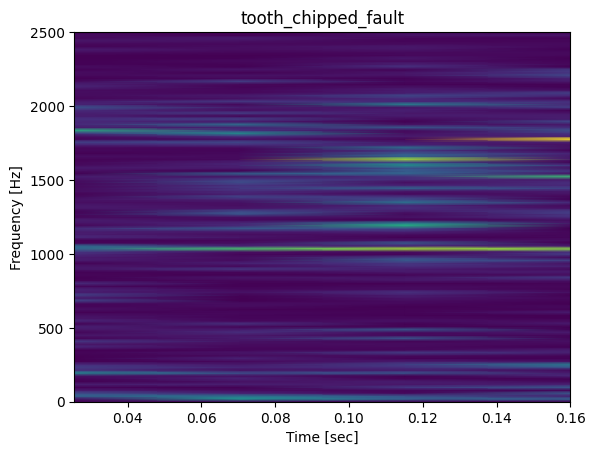

In [62]:
for defect_name in big_data.defect.unique():
    f, t, Sxx = signal.spectrogram(big_data[big_data['defect'] == defect_name].drop(columns=['defect', 'velocity', 'load']).values[0, :], fs=1/0.0002)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(defect_name)
    plt.show()

In [63]:
X = big_data.drop(columns=['defect', 'velocity', 'load']).values
X

array([[3.50379405, 3.50428424, 3.50129566, ..., 3.50274679, 3.50264556,
        3.50485411],
       [3.50289507, 3.50151028, 3.50099855, ..., 3.50471463, 3.50404767,
        3.50229077],
       [3.50137461, 3.50333378, 3.50392939, ..., 3.50417463, 3.5032113 ,
        3.50333378],
       ...,
       [3.50092924, 3.5066971 , 3.51720495, ..., 3.49507816, 3.49268602,
        3.51980659],
       [3.48128927, 3.52228483, 3.50275087, ..., 3.49822915, 3.50997008,
        3.49572876],
       [3.51628254, 3.48185533, 3.49677765, ..., 3.47839219, 3.48592561,
        3.52036249]])

In [64]:
y = big_data['defect'].values
y

array(['eccentricity', 'eccentricity', 'eccentricity', 'eccentricity',
       'eccentricity', 'eccentricity', 'eccentricity', 'eccentricity',
       'eccentricity', 'eccentricity', 'eccentricity', 'eccentricity',
       'eccentricity', 'eccentricity', 'eccentricity', 'eccentricity',
       'eccentricity', 'eccentricity', 'eccentricity', 'eccentricity',
       'eccentricity', 'eccentricity', 'eccentricity', 'eccentricity',
       'eccentricity', 'missing_tooth', 'missing_tooth', 'missing_tooth',
       'missing_tooth', 'missing_tooth', 'missing_tooth', 'missing_tooth',
       'missing_tooth', 'missing_tooth', 'missing_tooth', 'missing_tooth',
       'missing_tooth', 'missing_tooth', 'missing_tooth', 'missing_tooth',
       'missing_tooth', 'missing_tooth', 'missing_tooth', 'missing_tooth',
       'missing_tooth', 'missing_tooth', 'missing_tooth', 'missing_tooth',
       'missing_tooth', 'missing_tooth', 'no_fault', 'no_fault',
       'no_fault', 'no_fault', 'no_fault', 'no_fault', 'no_f

In [65]:
loads = big_data['load'].astype(int).values
loads

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [66]:
velocities = big_data['velocity'].astype(int).values
velocities

array([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8

In [69]:
current_directory_path = os.getcwd()
n = big_data.shape[0]
for i in tqdm(range(n)):
    f, t, Sxx = signal.spectrogram(X[i, :], fs=5000.0)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.savefig(os.path.join(current_directory_path,
                                 y[i],
                                 f"{velocities[i]}_{loads[i]}_{i}.png"))
    plt.close()

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [01:16<00:00, 11.77it/s]


## Torch CV

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [71]:
directories = ['eccentricity', 'missing_tooth', 'no_fault', 'root_crack', 'surface_fault', 'tooth_chipped_fault']

In [72]:
list_images = []
list_labels = []
current_directory_path = os.getcwd()
for directory in directories:
    for image in os.listdir(directory):
        list_images.append(os.path.join(current_directory_path, directory, image))
        list_labels.append(directory)
d = pd.DataFrame({'path_to_image': list_images, 'label': list_labels})
encoder = LabelEncoder()
d['label'] = encoder.fit_transform(d['label'])
d.to_csv('annotation.csv')

In [73]:
d

,path_to_image,label
0,C:\Users\User\PycharmProjects\Gears\eccentrici...,0
1,C:\Users\User\PycharmProjects\Gears\eccentrici...,0
2,C:\Users\User\PycharmProjects\Gears\eccentrici...,0
3,C:\Users\User\PycharmProjects\Gears\eccentrici...,0
4,C:\Users\User\PycharmProjects\Gears\eccentrici...,0
...,...,...
895,C:\Users\User\PycharmProjects\Gears\tooth_chip...,5
896,C:\Users\User\PycharmProjects\Gears\tooth_chip...,5
897,C:\Users\User\PycharmProjects\Gears\tooth_chip...,5
898,C:\Users\User\PycharmProjects\Gears\tooth_chip...,5


In [74]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        self.img_labels = pd.read_csv(annotations_file, index_col=0)
        self.transform = transform
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels['path_to_image'][idx]
        image = read_image(img_path, mode=ImageReadMode.RGB)
        label = self.img_labels['label'][idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [75]:
transforms = v2.Compose([
    v2.Resize(size=(227, 227), antialias=True),  # Or Resize(antialias=True)
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [76]:
train_image_dataset = CustomImageDataset(annotations_file='annotation.csv', transform=transforms)

In [77]:
train_size = int(0.8 * len(train_image_dataset))
test_size = len(train_image_dataset) - train_size
generator1 = torch.Generator().manual_seed(861)
train_image_dataset, val_image_dataset = torch.utils.data.random_split(train_image_dataset, [train_size, test_size], generator=generator1)

In [79]:
train_dataloader = DataLoader(train_image_dataset, batch_size=6, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


surface_fault


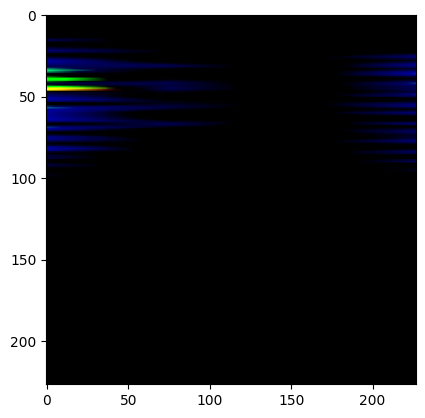

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eccentricity


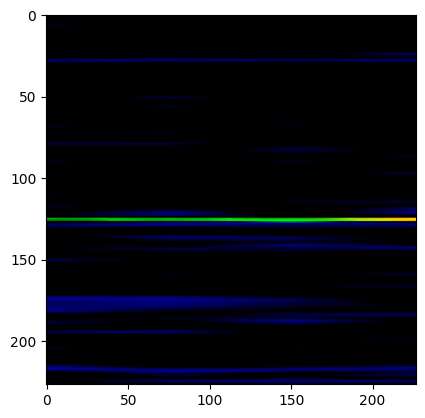

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


missing_tooth


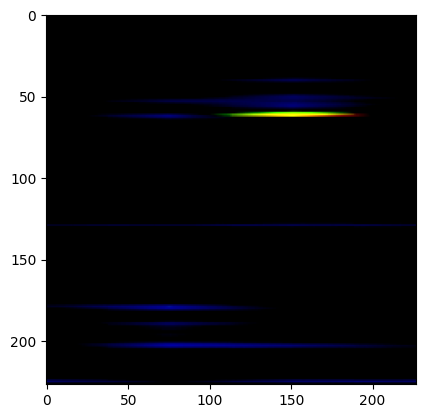

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tooth_chipped_fault


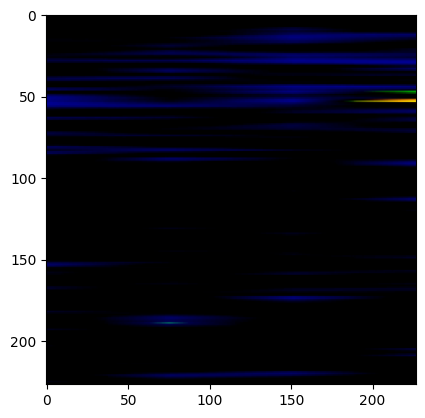

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


missing_tooth


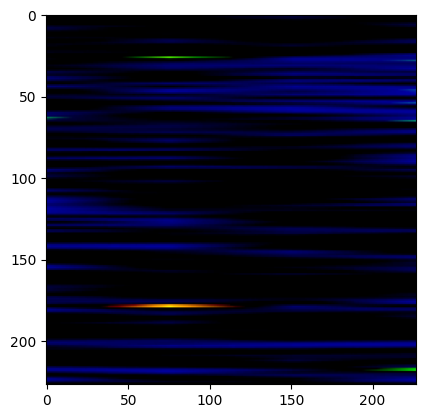

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


no_fault


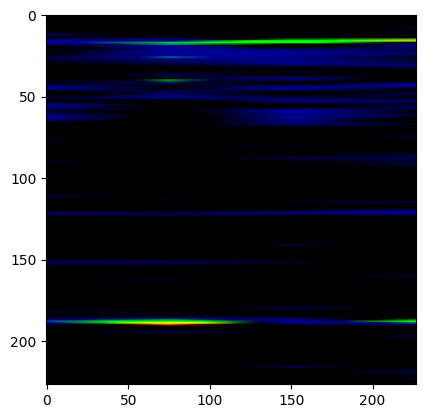

In [80]:
for X_train, y_train in train_dataloader:
    X_train = X_train
    y_train = y_train
    break
for i in range(X_train.size()[0]):
    label = np.array([y_train[i].item()])
    print(encoder.inverse_transform(label)[0])
    plt.imshow(X_train[i].permute(1, 2, 0))
    plt.show()

In [81]:
train_dataloader = DataLoader(train_image_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_image_dataset, batch_size=16, shuffle=True)

In [82]:
model = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights)
for param in model.parameters():
    param.requires_grad_ = False
model.fc.out_features = 6

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [83]:
criterion = torch.nn.CrossEntropyLoss()
optimezer = torch.optim.Adam(params=model.parameters(), lr=0.005)
scheduler = lr_scheduler.ExponentialLR(optimezer, gamma=0.5)

In [84]:
epochs = 10
train_loss_values = []
test_loss_values = []
train_accuracy = []
test_accuracy = []
model.to(device)
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()
    for i, (X_train, label) in enumerate(train_dataloader):
        X_train = X_train.to(device)
        label = label.to(device)
        optimezer.zero_grad()
        prediction = model(X_train)
        _, predictions = torch.max(prediction.data, 1)
        loss = criterion(prediction, label)
        loss.backward()
        optimezer.step()
        running_loss += loss.item()
        total += label.size(0)
        correct += (predictions == label).sum().item()
    print(f'Epoch №{epoch + 1}, Training loss = {running_loss / len(train_dataloader)}')
    print(f'Epoch №{epoch + 1}, Accuracy on train = {correct / total * 100}%')
    train_loss_values.append(running_loss / len(train_dataloader))
    train_accuracy.append(correct / total * 100)
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        model.eval()
        for X_val, label_val in val_dataloader:
            X_val = X_val.to(device)
            label_val = label_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, label_val)
            running_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            total += label_val.size(0)
            correct += (predictions == label_val).sum().item()
    scheduler.step()
    print(f'Epoch №{epoch + 1}, Test loss = {running_loss / len(val_dataloader)}')
    print(f'Epoch №{epoch + 1}, Accuracy on test = {correct / total * 100}%')
    test_loss_values.append(running_loss / len(train_dataloader))
    test_accuracy.append(correct / total * 100)
    print('----------------------------------------------------------------')

Epoch №1, Training loss = 2.1098790605862936
Epoch №1, Accuracy on train = 36.25%
Epoch №1, Test loss = 1.3268196284770966
Epoch №1, Accuracy on test = 48.333333333333336%
----------------------------------------------------------------
Epoch №2, Training loss = 1.1223380823930105
Epoch №2, Accuracy on train = 58.88888888888889%
Epoch №2, Test loss = 1.1315016349156697
Epoch №2, Accuracy on test = 53.888888888888886%
----------------------------------------------------------------
Epoch №3, Training loss = 0.6345565186606513
Epoch №3, Accuracy on train = 76.25%
Epoch №3, Test loss = 0.642220369229714
Epoch №3, Accuracy on test = 80.55555555555556%
----------------------------------------------------------------
Epoch №4, Training loss = 0.400096696946356
Epoch №4, Accuracy on train = 86.38888888888889%
Epoch №4, Test loss = 0.5397875209649404
Epoch №4, Accuracy on test = 81.66666666666667%
----------------------------------------------------------------
Epoch №5, Training loss = 0.2835

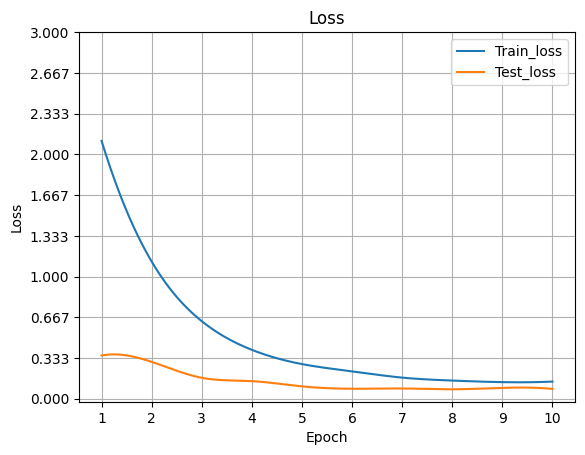

In [85]:
from scipy.interpolate import make_interp_spline

#create data
x = np.array([i + 1 for i in range(epochs)])
y1 = np.array(train_loss_values)
y2 = np.array(test_loss_values)
xnew = np.linspace(x.min(), x.max(), 200) 

#define spline
spl1 = make_interp_spline(x, y1, k=3)
y_smooth1 = spl1(xnew)
spl2 = make_interp_spline(x, y2, k=3)
y_smooth2 = spl2(xnew)
#create smooth line chart 
plt.plot(xnew, y_smooth1, label='Train_loss')
plt.plot(xnew, y_smooth2, label='Test_loss')
plt.xticks([i + 1 for i in range(epochs)])
plt.yticks(np.linspace(np.floor(min(train_loss_values + test_loss_values)), np.ceil(max(train_loss_values + test_loss_values)), 10))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid()
plt.legend()
plt.show()

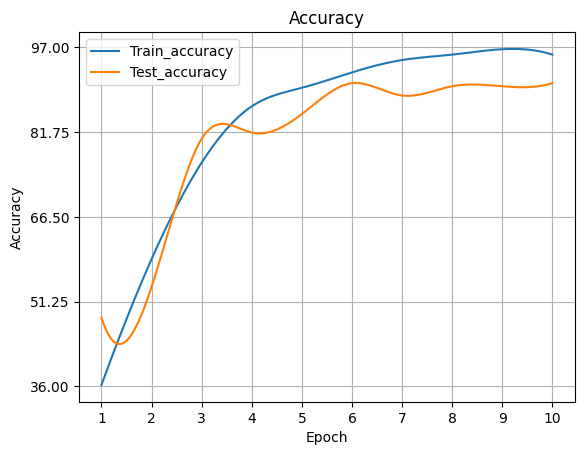

In [86]:
x = np.array([i + 1 for i in range(epochs)])
y1 = np.array(train_accuracy)
y2 = np.array(test_accuracy)
xnew = np.linspace(x.min(), x.max(), 200) 

#define spline
spl1 = make_interp_spline(x, y1, k=3)
y_smooth1 = spl1(xnew)
spl2 = make_interp_spline(x, y2, k=3)
y_smooth2 = spl2(xnew)
#create smooth line chart 
plt.plot(xnew, y_smooth1, label='Train_accuracy')
plt.plot(xnew, y_smooth2, label='Test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([i + 1 for i in range(epochs)])
plt.yticks(np.linspace(np.floor(min(train_accuracy + test_accuracy)), np.ceil(max(train_accuracy + test_accuracy)), 5))
plt.title('Accuracy')
plt.grid()
plt.legend()
plt.show()